# GSplatting Test (L4 GPU)

## Basic Setup

In [ ]:
import os, sys
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/TUWien/MasterThesisNeRF/gsplat"

/content/drive/MyDrive/TUWien/MasterThesisNeRF/gsplat


## Libraries

Only execute once!

In [ ]:
# !pip install --target="./lib" https://github.com/nerfstudio-project/gsplat/releases/download/v1.4.0/gsplat-1.4.0+pt24cu121-cp310-cp310-linux_x86_64.whl

In [ ]:
# !pip install --target="./lib" plyfile

In [ ]:
# # Link is dead for actual simple-knn repo so i am using my alternative fork :P
# !git clone https://github.com/PaulErpen/mini-splatting-capped.git
# %cd "/content/drive/MyDrive/TUWien/MasterThesisNeRF/gsplat/mini-splatting-capped/submodules/simple-knn"
# !pip install --target="../../../lib" .
# %cd "/content/drive/MyDrive/TUWien/MasterThesisNeRF/gsplat"

## Library Import

In [ ]:
# add lib to path
import sys

sys.path.append("/content/drive/MyDrive/TUWien/MasterThesisNeRF/gsplat/lib")

## Dataset loading

### Initial points loading

In [ ]:
from typing import NamedTuple
from plyfile import PlyElement, PlyData

class BasicPointCloud(NamedTuple):
  points : np.array
  colors : np.array
  normals : np.array

In [ ]:
def storePly(path, xyz, rgb):
  # Define the dtype for the structured array
  dtype = [('x', 'f4'), ('y', 'f4'), ('z', 'f4'),
          ('nx', 'f4'), ('ny', 'f4'), ('nz', 'f4'),
          ('red', 'u1'), ('green', 'u1'), ('blue', 'u1')]

  normals = np.zeros_like(xyz)

  elements = np.empty(xyz.shape[0], dtype=dtype)
  attributes = np.concatenate((xyz, normals, rgb), axis=1)
  elements[:] = list(map(tuple, attributes))

  # Create the PlyData object and write to file
  vertex_element = PlyElement.describe(elements, 'vertex')
  ply_data = PlyData([vertex_element])
  ply_data.write(path)

In [ ]:
def fetchPly(path):
  plydata = PlyData.read(path)
  vertices = plydata['vertex']
  positions = np.vstack([vertices['x'], vertices['y'], vertices['z']]).T
  colors = np.vstack([vertices['red'], vertices['green'], vertices['blue']]).T / 255.0
  normals = np.vstack([vertices['nx'], vertices['ny'], vertices['nz']]).T
  return BasicPointCloud(points=positions, colors=colors, normals=normals)

In [ ]:

import numpy as np
C0 = 0.28209479177387814

def SH2RGB(sh):
    return sh * C0 + 0.5

def load_initial_points(dataset_path: str, num_points: int) -> BasicPointCloud:
  ply_path = os.path.join(dataset_path, "points3d.ply")

  if not os.path.exists(ply_path):
    print(f"Generating random point cloud ({num_points})...")

    # We create random points inside the bounds of the synthetic Blender scenes
    xyz = np.random.random((num_points, 3)) * 2.6 - 1.3
    shs = np.random.random((num_points, 3)) / 255.0
    pcd = BasicPointCloud(points=xyz, colors=SH2RGB(shs), normals=np.zeros((num_points, 3)))

    storePly(ply_path, xyz, SH2RGB(shs) * 255)
  else:
    pcd = fetchPly(ply_path)

    if pcd.points.shape[0] > num_points:
      print(f"Subsampling point cloud ({num_points})...")
      np.random.seed(123)
      chosen_points = np.random.choice(pcd.points.shape[0], num_points, replace=False)
      pcd = BasicPointCloud(pcd.points[chosen_points], pcd.colors[chosen_points], pcd.normals[chosen_points])

  return pcd

### Helper Methods

In [ ]:
from pathlib import Path
from PIL import Image
from typing import Tuple
import torch

def image_path_to_tensors(image_path: Path) -> Tuple[torch.Tensor, torch.Tensor]:
    import torchvision.transforms as transforms

    img = Image.open(image_path)
    transform = transforms.ToTensor()
    img_tensor = transform(img).permute(1, 2, 0)[..., :3]
    alpha_tensor = transform(img).permute(1, 2, 0)[..., 3:]
    return img_tensor, alpha_tensor

In [ ]:
def compute_intrinsics_matrix(focal_length, width, height):
    return torch.tensor(
        [
            [focal_length, 0, width / 2],
            [0, focal_length, height / 2],
            [0, 0, 1],
        ]
    )

In [ ]:
import numpy as np

def transform_matrix_to_w2c(transform_matrix):
    c2w = transform_matrix
    c2w[:3, 1:3] *= -1 # change axis convention from Blender to colmap
    return np.linalg.inv(c2w)

In [ ]:
from typing import NamedTuple
from torch.linalg import vector_norm

class NerfNorm(NamedTuple):
  translation: torch.tensor
  radius: float

def getNerfppNorm(w2c):
    def get_center_and_diag(cam_centers):
        cam_centers = np.hstack(cam_centers)
        avg_cam_center = np.mean(cam_centers, axis=1, keepdims=True)
        center = avg_cam_center
        dist = np.linalg.norm(cam_centers - center, axis=0, keepdims=True)
        diagonal = np.max(dist)
        return center.flatten(), diagonal

    cam_centers = []

    for i in range(w2c.shape[0]):
        C2W = np.linalg.inv(w2c[i])
        cam_centers.append(C2W[:3, 3:4])

    center, diagonal = get_center_and_diag(cam_centers)
    radius = diagonal * 1.1

    translate = -center

    return NerfNorm(translate, diagonal)

# def getNerfppNorm(w2c) -> NerfNorm:
#     c2w = torch.inverse(w2c)
#     translation = c2w[:, :3, 3]
#     b = c2w.shape[0]
#
#     assert translation.shape == (b, 3), translation.shape
#
#     center = torch.mean(translation, 0)
#
#     assert center.shape == (3,), center.shape
#
#     centered = translation - center
#     assert centered.shape == (b, 3), centered.shape
#     distance = vector_norm(centered, dim=0, keepdim=True)
#     assert distance.shape == (1, 3), distance.shape
#     diagonal = torch.max(distance).float()
#
#     translate = -center
#
#     return NerfNorm(translate, diagonal * 1.1)

In [ ]:
w2c = torch.eye(4).repeat(10000, 1, 1)
w2c[:, :3, 3] = (torch.rand_like(w2c[:, :3, 3]) - 0.5) * 3

norm = getNerfppNorm(w2c)

assert norm.translation.shape == (3,)
assert norm.radius > 0

In [ ]:
vector_norm(torch.tensor([[0.5, 0.5, 0.5]]) * 3, dim=1)* 1.1

tensor([2.8579])

In [ ]:
norm

NerfNorm(translation=array([ 0.00331493, -0.00787695,  0.01250248], dtype=float32), radius=2.5076003)

In [ ]:
torch.rand_like(w2c[:, :3, 3])

tensor([[0.4718, 0.5404, 0.3595],
        [0.7933, 0.7835, 0.4658],
        [0.7540, 0.7996, 0.4390],
        ...,
        [0.2286, 0.8362, 0.1465],
        [0.7621, 0.0845, 0.4141],
        [0.1939, 0.1336, 0.9147]])

### Blender Dataset

In [ ]:
from typing import Callable, Literal, Tuple
import torch.utils.data
import json
from pathlib import Path
import numpy as np
import PIL.Image


class BlenderSyntheticDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        data_root: str,
        split: Literal["train", "val", "test"],
        max_num_init_points: int,
        limit: int | None = None,
    ):
        self.meta = {}
        self.split = split
        self.data_root = Path(data_root)
        self.image_size = (800, 800)
        self.bg_color = torch.Tensor([1.0, 1.0, 1.0])

        meta_path = Path(data_root) / Path("transforms_{}.json".format(self.split))

        if not self.data_root.exists() or not meta_path.exists():
            raise FileNotFoundError(
                "The specified split file does not exist: {}".format(self.data_root)
            )

        with open(meta_path, "r") as fp:
            self.meta = json.load(fp)

        tmp_img = []
        tmp_alpha = []
        poses = []
        for idx, frame in enumerate(self.meta["frames"]):
            if limit is not None and idx >= limit:
                break

            img_path = self.data_root / Path(frame["file_path"] + ".png")
            # Load the image
            img, alpha = image_path_to_tensors(img_path)
            tmp_img.append(img)
            tmp_alpha.append(alpha)
            poses.append(transform_matrix_to_w2c(np.array(frame["transform_matrix"])))
        poses = np.array(poses).astype(np.float32)
        self.poses = torch.from_numpy(poses)
        self.images = torch.stack(tmp_img, dim=0)
        self.alphas = torch.stack(tmp_alpha, dim=0)
        self.camera_angle_x = float(self.meta["camera_angle_x"])

        self.focal_length = (
            0.5 * 800 / np.tan(0.5 * self.camera_angle_x)
        )
        self.intrinsics = compute_intrinsics_matrix(
            self.focal_length, self.image_size[0], self.image_size[1]
        )

        self.pcd = load_initial_points(self.data_root, max_num_init_points)

        self.norm = getNerfppNorm(self.poses)

    def __len__(self):
        return self.poses.shape[0]

    def __getitem__(self, idx) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.poses[idx], self.images[idx], self.alphas[idx]


### Blender Dataset - Tests

In [ ]:
# Test: Given a valid dataset path, when retrieving the first observation, the image must have the correct shape

dataset = BlenderSyntheticDataset(data_root="../nerf-synthetic/lego", split="train", max_num_init_points=100, limit=3)

assert dataset[0][1].shape == (800, 800, 3), dataset[0][1].shape

Subsampling point cloud (100)...


In [ ]:
assert dataset[0][2].shape == (800, 800, 1), dataset[0][1].shape

In [ ]:
assert dataset[0][0].shape == (4, 4), dataset[0][0].shape

In [ ]:
assert dataset.intrinsics.shape == (3, 3), dataset.intrinsics.shape

In [ ]:
# Test: Given a dataset that subsamples the initial point cloud, then the point cloud should only contain the number of specified points

assert dataset.pcd.points.shape[0] == 100, dataset.pcd.points.shape[0]
assert dataset.pcd.colors.shape[0] == 100, dataset.pcd.colors.shape[0]
assert dataset.pcd.normals.shape[0] == 100, dataset.pcd.normals.shape[0]

In [ ]:
from numpy.testing import assert_almost_equal

dataset = BlenderSyntheticDataset(data_root="../nerf-synthetic/lego", split="train", max_num_init_points=100)

assert_almost_equal(dataset.norm.radius, 4.789909410476685, decimal=1, err_msg=f"Dataset norm radius ({dataset.norm.radius}) derives to much from {4.789909410476685}")

Subsampling point cloud (100)...


## Gaussian Model

In [ ]:
import torch

def rgb_to_sh(rgb: torch.Tensor) -> torch.Tensor:
    C0 = 0.28209479177387814
    return (rgb - 0.5) / C0

In [ ]:
def inverse_sigmoid(x):
    return torch.log(x/(1-x))

In [ ]:
import torch.nn

class GaussianParamsModel:
  def get_params(self):
    raise NotImplementedError()

  def set_params(self, params: torch.nn.ParameterDict):
    raise NotImplementedError()

In [ ]:
import torch
from torch import nn
import math
from gsplat import rasterization
from torch import optim
from typing import Dict
from simple_knn._C import distCUDA2

class GaussianModel(nn.Module, GaussianParamsModel):
  def __init__(self,
               params: nn.ParameterDict,
               scene_scale: float,
               sh_degree: int = 3):
    super(GaussianModel, self).__init__()

    self.sh_degree = sh_degree
    self.scene_scale = scene_scale
    self.params = params

  @classmethod
  def from_point_cloud(cls, pcd: BasicPointCloud, scene_scale: float, sh_degree: int = 3):
    points = torch.tensor(np.asarray(pcd.points)).float()
    num_points = points.shape[0]

    # color is SH coefficients.
    colors = torch.zeros((num_points, (sh_degree + 1) ** 2, 3))  # [N, K, 3]
    colors[:, 0, :] = rgb_to_sh(torch.tensor(np.asarray(pcd.colors)).float())

    dist2 = torch.clamp_min(distCUDA2(torch.from_numpy(np.asarray(pcd.points)).float().cuda()), 0.0000001)
    scales = torch.log(torch.sqrt(dist2))[...,None].repeat(1, 3)

    opacities = inverse_sigmoid(0.1 * torch.ones((num_points), dtype=torch.float, device="cuda"))

    params = nn.ParameterDict({
        "means": nn.Parameter(
          points.to(torch.float32)
        ),
        "scales": nn.Parameter(
          scales.to(torch.float32)
        ),
        "quats": nn.Parameter(
          torch.rand((num_points, 4)).to(torch.float32)
        ),
        "opacities": opacities,
        "sh0": torch.nn.Parameter(colors[:, :1, :]),
        "shN": torch.nn.Parameter(colors[:, 1:, :])
    })

    return cls(params, scene_scale, sh_degree)

  def get_params(self):
    return self.params

  def set_params(self, params: torch.nn.ParameterDict):
    self.params = params

  def forward(self,
              view_matrix: torch.Tensor,
              K: torch.Tensor,
              W: int,
              H: int,
              bg_color: torch.Tensor | None):
    colors = torch.cat([self.params["sh0"], self.params["shN"]], 1)

    renders, alphas, info = rasterization(
      means=self.params["means"],
      quats=self.params["quats"],
      scales=torch.exp(self.params["scales"]),
      opacities=torch.sigmoid(self.params["opacities"]),
      colors=colors,
      viewmats=view_matrix,
      Ks=K,
      width=W,
      height=H,
      packed=False,
      sh_degree=self.sh_degree,
      backgrounds=bg_color
    )
    return renders, alphas, info

### Gaussian Model - Tests

In [ ]:
# Test: Given a valid gaussian model, when forwarding with camera parameters, then return an image batch of the correct dimensions

example_dataset = BlenderSyntheticDataset(data_root="../nerf-synthetic/lego", split="train", max_num_init_points=2000, limit=1)
gaussian_model  = GaussianModel.from_point_cloud(example_dataset.pcd, example_dataset.norm.radius).to("cuda")

assert gaussian_model(
  torch.eye(4).unsqueeze(0).to("cuda"),
  torch.eye(3).unsqueeze(0).to("cuda"),
  800,
  800,
  torch.ones(1, 3).to("cuda")
)[0].shape == (1, 800, 800, 3)

Subsampling point cloud (2000)...


In [ ]:
gaussian_model(
  torch.eye(4).unsqueeze(0).to("cuda"),
  torch.eye(3).unsqueeze(0).to("cuda"),
  800,
  800,
  torch.ones(1, 3).to("cuda")
)[2].keys()

dict_keys(['camera_ids', 'gaussian_ids', 'radii', 'means2d', 'depths', 'conics', 'opacities', 'tile_width', 'tile_height', 'tiles_per_gauss', 'isect_ids', 'flatten_ids', 'isect_offsets', 'width', 'height', 'tile_size', 'n_cameras'])

In [ ]:
gaussian_model(
  torch.eye(4).unsqueeze(0).to("cuda"),
  torch.eye(3).unsqueeze(0).to("cuda"),
  800,
  800,
  torch.ones(1, 3).to("cuda")
)[2]["isect_ids"]

tensor([    1009870466,     1012387227,     1012737766,  ...,
        10734142899248, 10734143237084, 10734147164268], device='cuda:0')

In [ ]:
assert gaussian_model.params["quats"].shape == (2000, 4), gaussian_model.params["quats"].shape

## Optimizer Factory

In [ ]:
from typing import Dict, Union

class OptimizerFactory:
  @staticmethod
  def create_optimizers(model: GaussianModel, lr_by_name: Union[None, Dict[str, float]] = None) -> Dict:
    if lr_by_name is None:
      lr_by_name = OptimizerFactory.get_default_learning_rates(model.scene_scale)

    optimizers = {}

    for name, parameters in model.params.items():
      lr = lr_by_name[name]

      if lr is None:
        raise ValueError(f"No learning rate for {name}")

      optimizers[name] = optim.Adam(
          [{"params": parameters, "lr": lr, "name": name}]
      )

    return optimizers

  @staticmethod
  def get_default_learning_rates(spatial_lr_scale: float) -> Dict[str, float]:
    return {
      "means": 1.6e-4 * spatial_lr_scale,
      "scales": 5e-3,
      "quats": 1e-3,
      "opacities": 5e-2,
      "sh0": 2.5e-3,
      "shN": 2.5e-3 / 20
    }

In [ ]:
# Test: given a gaussian model, when creating the optimizers, then return a dict with the correct amount of keys

dataset = BlenderSyntheticDataset(data_root="../nerf-synthetic/lego", split="train", max_num_init_points=2000, limit=1)
gaussian_model  = GaussianModel.from_point_cloud(dataset.pcd, dataset.norm.radius)

optimizers = OptimizerFactory.create_optimizers(gaussian_model)

assert len(optimizers) == len(gaussian_model.params)

Subsampling point cloud (2000)...


## Scheduler Factory

In [ ]:
from typing import Dict, List

class SchedulerFactory:
  @staticmethod
  def create_schedulers(optimizers: Dict, config: "Config") -> List:
    schedulers = [
        torch.optim.lr_scheduler.ExponentialLR(
          optimizers["means"], gamma=0.01 ** (1.0 / config.max_steps)
        )
    ]
    return schedulers

## Holdoutview-Handler

In [ ]:
class HoldoutViewHandler:
    def __init__(self,
                 holdout_view_matrix: torch.Tensor,
                 K: torch.Tensor,
                 W: int,
                 H: int,
                 out_dir: str,
                 bg_color: torch.Tensor | None,
                 device="cuda"):
        self.holdout_view_matrix = holdout_view_matrix.to(torch.float32)
        self.K = K.to(torch.float32)
        self.W = W
        self.H = H
        self.frames = []
        self.bg_color = bg_color
        self.device = device
        self.out_dir = out_dir

    def to(self, device):
        self.device = device
        self.holdout_view_matrix = self.holdout_view_matrix.to(device)
        self.K = self.K.to(device)
        return self

    def compute_holdout_view(self, model: nn.Module):
        renders, _, _ = model(
            self.holdout_view_matrix.unsqueeze(0).to(self.device),
            self.K.unsqueeze(0).to(self.device),
            self.W,
            self.H,
            self.bg_color.unsqueeze(0).to(self.device),
        )
        out_img = renders[0]
        out_img = torch.clamp(out_img, 0.0, 1.0)
        self.frames.append((out_img.detach().cpu().numpy() * 255).astype(np.uint8))

    def export_gif(self):
      frames = [Image.fromarray(frame) for frame in self.frames]
      export_dir = os.path.join(os.getcwd(), self.out_dir)
      os.makedirs(self.out_dir, exist_ok=True)
      frames[0].save(
          f"{export_dir}/training.gif",
          save_all=True,
          append_images=frames[1:],
          optimize=False,
          duration=5,
          loop=0,
        )

### Holdoutview-Handler - Tests

In [ ]:
# Test: Given a valid holdout view handler, when computing a set of views and exporting, then the gif must exist

import os
import shutil

shutil.rmtree("unittests/test-renders", ignore_errors=True)

os.makedirs("unittests/test-renders", exist_ok=True)

class MockedModel(nn.Module):
  def __init__(self):
    super(MockedModel, self).__init__()

  def forward(self,
              view_matrix: torch.Tensor,
              K: torch.Tensor,
              W: int,
              H: int,
              bg_color: torch.Tensor | None):
    return torch.rand(1, 800, 800, 3), torch.rand(1), torch.rand(1)

gaussian_model = MockedModel()


holdout_view_handler = HoldoutViewHandler(torch.eye(4),
                                          torch.eye(3),
                                          800,
                                          800,
                                          bg_color=torch.rand(3),
                                          out_dir = "unittests/test-renders")

holdout_view_handler.compute_holdout_view(gaussian_model)
holdout_view_handler.export_gif()

assert os.path.exists("unittests/test-renders/training.gif")

## Logger

In [ ]:
import wandb

class Logger:
    def __init__(self,
                 wandb_project: str,
                 wandb_run_name: str,
                 wandb_key_file_path: str,
                 device: str):

        self.wandb_project = wandb_project
        self.wandb_run_name = wandb_run_name

        with open(wandb_key_file_path, "r") as f:
            self.wandb_key = f.read().strip()
        self.device = device

        wandb.login(key=self.wandb_key)
        self.run = wandb.init(project=self.wandb_project, name=self.wandb_run_name)

    def log(self, dict: Dict, iteration: int):
        self.run.log(dict, step=iteration)

    def finish(self):
        self.run.finish()

### Logger - Tests

In [ ]:
# Test: Given a valid wandb API key, when initializing, then no error must be thrown

# Logger("unittests", "unittest-run", "/content/drive/MyDrive/TUWien/MasterThesisNeRF/gsplat/wandb-api-key.txt", "cuda").finish()
# test to slow!

## Add Background

In [ ]:
import torch

def add_backround(rgbs: torch.Tensor, background: torch.Tensor, alpha: torch.Tensor) -> torch.Tensor:
  blended_image = rgbs * alpha + background * (1 - alpha)

  return blended_image

### Add background test

Subsampling point cloud (200)...


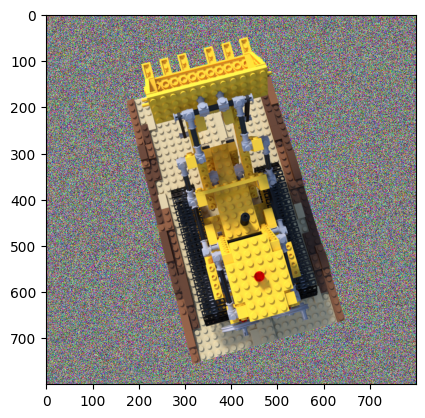

In [ ]:
# Given an observation from a blender synthetic dataset, when adding a background, display the background

import matplotlib.pyplot as plt

blender_synthetic_dataset = BlenderSyntheticDataset(data_root="../nerf-synthetic/lego", split="val", max_num_init_points=200, limit=1)
observation = next(iter(blender_synthetic_dataset))
rgb = observation[1]
alpha = observation[2]

bg_image = torch.rand(800, 800, 3)

blended_image = add_backround(rgb, bg_image, alpha)

plt.imshow(blended_image)
plt.show()

## Metrics

### SSIM

In [ ]:
from torch.autograd import Variable
from math import exp
import torch.nn.functional as F

def ssim(img1, img2, window_size=11, size_average=True):
    channel = img1.size(-3)
    window = create_window(window_size, channel)

    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)

    mu1 = F.conv2d(img1, window, padding=window_size // 2, groups=channel)
    mu2 = F.conv2d(img2, window, padding=window_size // 2, groups=channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv2d(img1 * img1, window, padding=window_size // 2, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=window_size // 2, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, window, padding=window_size // 2, groups=channel) - mu1_mu2

    C1 = 0.01 ** 2
    C2 = 0.03 ** 2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size // 2) ** 2 / float(2 * sigma ** 2)) for x in range(window_size)])
    return gauss / gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

#### SSIM Metric - Tests

In [ ]:
# Given two images that are the same, when computing the ssim it must be one

im1 = torch.ones(1, 800, 800, 3)
im2 = torch.ones(1, 800, 800, 3)

assert ssim(im1, im2) == 1.0

In [ ]:
# Given two images that are the opposite, when computing the ssim it must be almost zero
from numpy.testing import assert_almost_equal

im1 = torch.ones(1, 800, 800, 3)
im2 = torch.zeros(1, 800, 800, 3)

assert_almost_equal(ssim(im1, im2), 0.0, 6)

### PSNR

In [ ]:
def psnr(img1, img2):
    mse = (((img1 - img2)) ** 2).view(img1.shape[0], -1).mean(1, keepdim=True)
    return 20 * torch.log10(1.0 / torch.sqrt(mse)).mean().double()

#### PSNR - Tests

In [ ]:
# Given two images that are the opposite, when computing the psnr then it must be zero

im1 = torch.ones(1, 800, 800, 3)
im2 = torch.zeros(1, 800, 800, 3)

assert psnr(im1, im2) == 0.0

In [ ]:
# Given two images that are the same, when computing the psnr it must be infinite

import numpy as np

im1 = torch.ones(1, 800, 800, 3)
im2 = torch.ones(1, 800, 800, 3)

assert psnr(im1, im2) == np.Inf

In [ ]:
# Given two images that are random, when computing the psnr the value must be finite

import numpy as np

im1 = torch.rand(1, 800, 800, 3)
im2 = torch.rand(1, 800, 800, 3)

assert np.isfinite(psnr(im1, im2))

## Config

In [ ]:
from dataclasses import dataclass, field
from typing import List

@dataclass
class Config:
  # INITIALIZATION
  # Radius of the scene (Especially important for NeRF data i think)
  scene_radius: float = 1.0
  # Initial number of Gaussians
  init_num_gaussians: int = 2000

  # RENDERING
  # Use packed mode for rasterization, this leads to less memory usage but slightly slower.
  packed: bool = False

  # TRAINING
  # Strategy to use for densifying the gaussians
  strategy_type: Literal["mcmc"] = "mcmc"
  # Number of training steps
  max_steps: int = 10_000
  # Opacity regularization
  opacity_reg: float = 0.0
  # Scale regularization
  scale_reg: float = 0.0
  # the frequency with which holdout views are created
  holdout_view_frequency: int = 20
  # the amount of ssim included in the loss
  ssim_lambda: float = 0.2
  max_num_gaussians: int = 12000
  # the exact iterations when the testing loop is supposed to be executed
  test_iterations: List[int] = field(default_factory=lambda: [500, 1000, 5000, 7500, 9000, 10000])
  # Wether to print verbose info
  verbose: bool = False
  # maximum cap for the number of gaussians
  cap_max: int = 12_000
  # MCMC samping noise learning rate. Default to 5e5.
  noise_lr: float = 5e5
  # Start refining GSs after this iteration. Default to 500.
  refine_start_iter: int = 500
  # Stop refining GSs after this iteration. Default to 25_000.
  refine_stop_iter: int = 25_000
  # Refine GSs every this steps. Default to 100.
  refine_every: int = 100
  # GSs with opacity below this value will be pruned. Default to 0.005.
  min_opacity: float = 0.005


## Strategies

### MCMC Strategy

In [ ]:
import math
from dataclasses import dataclass
from typing import Any, Dict, Union, Tuple

import torch
from torch import Tensor

from gsplat.strategy import Strategy
from gsplat.strategy.ops import inject_noise_to_position, relocate, sample_add


@dataclass
class MCMCStrategy(Strategy):
    """Strategy that follows the paper:

    `3D Gaussian Splatting as Markov Chain Monte Carlo <https://arxiv.org/abs/2404.09591>`_

    This strategy will:

    - Periodically teleport GSs with low opacity to a place that has high opacity.
    - Periodically introduce new GSs sampled based on the opacity distribution.
    - Periodically perturb the GSs locations.

    Args:
        cap_max (int): Maximum number of GSs. Default to 1_000_000.
        noise_lr (float): MCMC samping noise learning rate. Default to 5e5.
        refine_start_iter (int): Start refining GSs after this iteration. Default to 500.
        refine_stop_iter (int): Stop refining GSs after this iteration. Default to 25_000.
        refine_every (int): Refine GSs every this steps. Default to 100.
        min_opacity (float): GSs with opacity below this value will be pruned. Default to 0.005.
        verbose (bool): Whether to print verbose information. Default to False.

    Examples:

        >>> from gsplat import MCMCStrategy, rasterization
        >>> params: Dict[str, torch.nn.Parameter] | torch.nn.ParameterDict = ...
        >>> optimizers: Dict[str, torch.optim.Optimizer] = ...
        >>> strategy = MCMCStrategy()
        >>> strategy.check_sanity(params, optimizers)
        >>> strategy_state = strategy.initialize_state()
        >>> for step in range(1000):
        ...     render_image, render_alpha, info = rasterization(...)
        ...     loss = ...
        ...     loss.backward()
        ...     strategy.step_post_backward(params, optimizers, strategy_state, step, info, lr=1e-3)

    """

    cap_max: int = 1_000_000
    noise_lr: float = 5e5
    refine_start_iter: int = 500
    refine_stop_iter: int = 25_000
    refine_every: int = 100
    min_opacity: float = 0.005
    verbose: bool = False

    def initialize_state(self) -> Dict[str, Any]:
        """Initialize and return the running state for this strategy."""
        n_max = 51
        binoms = torch.zeros((n_max, n_max))
        for n in range(n_max):
            for k in range(n + 1):
                binoms[n, k] = math.comb(n, k)
        return {"binoms": binoms}

    def check_sanity(
        self,
        params: Union[Dict[str, torch.nn.Parameter], torch.nn.ParameterDict],
        optimizers: Dict[str, torch.optim.Optimizer],
    ):
        """Sanity check for the parameters and optimizers.

        Check if:
            * `params` and `optimizers` have the same keys.
            * Each optimizer has exactly one param_group, corresponding to each parameter.
            * The following keys are present: {"means", "scales", "quats", "opacities"}.

        Raises:
            AssertionError: If any of the above conditions is not met.

        .. note::
            It is not required but highly recommended for the user to call this function
            after initializing the strategy to ensure the convention of the parameters
            and optimizers is as expected.
        """

        super().check_sanity(params, optimizers)
        # The following keys are required for this strategy.
        for key in ["means", "scales", "quats", "opacities"]:
            assert key in params, f"{key} is required in params but missing."

    # def step_pre_backward(
    #     self,
    #     params: Union[Dict[str, torch.nn.Parameter], torch.nn.ParameterDict],
    #     optimizers: Dict[str, torch.optim.Optimizer],
    #     # state: Dict[str, Any],
    #     step: int,
    #     info: Dict[str, Any],
    # ):
    #     """Callback function to be executed before the `loss.backward()` call."""
    #     pass

    def step_post_backward(
        self,
        params: Union[Dict[str, torch.nn.Parameter], torch.nn.ParameterDict],
        optimizers: Dict[str, torch.optim.Optimizer],
        state: Dict[str, Any],
        step: int,
        info: Dict[str, Any],
        lr: float,
    ) -> Tuple[int, int]:
        """Callback function to be executed after the `loss.backward()` call.

        Args:
            lr (float): Learning rate for "means" attribute of the GS.
        """
        # move to the correct device
        state["binoms"] = state["binoms"].to(params["means"].device)

        binoms = state["binoms"]

        n_new_gs = 0
        n_relocated_gs = 0

        if (
            step < self.refine_stop_iter
            and step > self.refine_start_iter
            and step % self.refine_every == 0
        ):
            # teleport GSs
            n_relocated_gs = self._relocate_gs(params, optimizers, binoms)
            if self.verbose:
                print(f"Step {step}: Relocated {n_relocated_gs} GSs.")

            # add new GSs
            n_new_gs = self._add_new_gs(params, optimizers, binoms)
            if self.verbose:
                print(
                    f"Step {step}: Added {n_new_gs} GSs. "
                    f"Now having {len(params['means'])} GSs."
                )

            torch.cuda.empty_cache()

        # add noise to GSs
        inject_noise_to_position(
            params=params, optimizers=optimizers, state={}, scaler=lr * self.noise_lr
        )

        return n_new_gs + n_relocated_gs, n_relocated_gs # n_created, n_deleted

    @torch.no_grad()
    def _relocate_gs(
        self,
        params: Union[Dict[str, torch.nn.Parameter], torch.nn.ParameterDict],
        optimizers: Dict[str, torch.optim.Optimizer],
        binoms: Tensor,
    ) -> int:
        opacities = torch.sigmoid(params["opacities"].flatten())
        dead_mask = opacities <= self.min_opacity
        n_gs = dead_mask.sum().item()
        if n_gs > 0:
            relocate(
                params=params,
                optimizers=optimizers,
                state={},
                mask=dead_mask,
                binoms=binoms,
                min_opacity=self.min_opacity,
            )
        return n_gs

    @torch.no_grad()
    def _add_new_gs(
        self,
        params: Union[Dict[str, torch.nn.Parameter], torch.nn.ParameterDict],
        optimizers: Dict[str, torch.optim.Optimizer],
        binoms: Tensor,
    ) -> int:
        current_n_points = len(params["means"])
        n_target = min(self.cap_max, int(1.05 * current_n_points))
        n_gs = max(0, n_target - current_n_points)
        if n_gs > 0:
            sample_add(
                params=params,
                optimizers=optimizers,
                state={},
                n=n_gs,
                binoms=binoms,
                min_opacity=self.min_opacity,
            )
        return n_gs

### Strategy Wrapper

In [ ]:
from typing import Tuple, Literal

class Strategy:
  def __init__(self, config: Config):
    if config.strategy_type == "mcmc":
      self.strategy = MCMCStrategy(
          cap_max=config.cap_max,
          noise_lr=config.noise_lr,
          refine_start_iter=config.refine_start_iter,
          refine_stop_iter=config.refine_stop_iter,
          refine_every=config.refine_every,
          min_opacity=config.min_opacity,
          verbose=config.verbose,
      )
      self.strategy_state = self.strategy.initialize_state()
    else:
      AssertionError(f"Unknown strategy {self.strategy}")

  def check_sanity(self, params, optimizers):
    self.strategy.check_sanity(params, optimizers)

  def step_pre_backward(self,
                        params,
                        optimizers,
                        step: int,
                        info):
    self.strategy.step_pre_backward(
      params=params,
      optimizers=optimizers,
      state=self.strategy_state,
      step=step,
      info=info,
    )

  def step_post_backward(self,
                         params,
                         optimizers,
                         step: int,
                         info,
                         packed,
                         schedulers) -> Tuple[int, int]:
    #if isinstance(self.strategy, DefaultStrategy):
    #  self.strategy.step_post_backward(
    #    params=params,
    #    optimizers=optimizers,
    #    state=self.strategy_state,
    #    step=step,
    #    info=info,
    #    packed=packed,
    #  )
    if isinstance(self.strategy, MCMCStrategy):
      return self.strategy.step_post_backward(
        params=params,
        optimizers=optimizers,
        state=self.strategy_state,
        step=step,
        info=info,
        lr=schedulers[0].get_last_lr()[0],
      )
    else:
      AssertionError(f"Unknown strategy {self.strategy}")

## Trainer

In [ ]:
import math
import os
import time
from pathlib import Path
from typing import Optional, List
import numpy as np
import torch
from PIL import Image
from torch import Tensor, optim
from torch.nn import functional as F

from matplotlib import pyplot as plt

class SimpleTrainer:
    """Trains random gaussians to fit an image."""

    def __init__(
        self,
        train_dataset: BlenderSyntheticDataset,
        test_dataset: BlenderSyntheticDataset,
        gaussian_model: GaussianModel,
        strategy: Strategy,
        optimizers: Dict,
        schedulers: List,
        holdout_view_handler: Optional[HoldoutViewHandler] = None,
        logger: Optional[Logger] = None,
        config: Config = Config()
    ):
        self.device = torch.device("cuda:0")
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.holdout_view_handler = holdout_view_handler.to(self.device)
        self.config = config
        self.holdout_view_frequency = config.holdout_view_frequency

        self.H, self.W = self.train_dataset.image_size
        self.img_size = torch.tensor([self.W, self.H, 1], device=self.device)

        self.gaussian_model = gaussian_model.to(self.device)

        self.optimizers = optimizers
        self.schedulers = schedulers

        self.strategy = strategy
        self.logger = logger

        self.strategy.check_sanity(self.gaussian_model.params, self.optimizers)

        self.cum_created = 0
        self.cum_deleted = 0

        self.bg_color = torch.ones(3).to(self.device)

    def train(
        self,
    ):
        frames = []
        times = [0] * 2  # rasterization, backward

        indeces = list(range(len(self.train_dataset)))

        # shuffle indeces
        np.random.shuffle(indeces)

        for iter in range(1, self.config.max_steps + 1):
            start = time.time()
            K = self.train_dataset.intrinsics.to(self.device).to(torch.float32)
            observation = self.train_dataset[indeces[(iter - 1) % len(indeces)]]
            viewmat = observation[0].to(self.device)
            gt_image = observation[1].to(self.device)
            gt_alpha = observation[2].to(self.device)

            bg_image = torch.ones_like(gt_image).to(self.device) * self.bg_color

            gt_image = add_backround(gt_image, bg_image, gt_alpha)

            renders, alphas, info = self.gaussian_model(
                viewmat.unsqueeze(0),
                K.unsqueeze(0),
                self.W,
                self.H,
                self.bg_color.unsqueeze(0)
            )
            info["means2d"].retain_grad()  # used for running stats

            out_img = renders[0]
            torch.cuda.synchronize()
            times[0] += time.time() - start

            self.strategy.step_pre_backward(
              params=self.gaussian_model.params,
              optimizers=self.optimizers,
              step=iter,
              info=info,
            )

            # loss
            l1loss = F.l1_loss(out_img, gt_image)
            ssimloss = 1.0 - ssim(
                out_img.permute(2, 0, 1).unsqueeze(0), gt_image.permute(2, 0, 1).unsqueeze(0)
            )
            ssim_lambda = self.config.ssim_lambda
            loss = l1loss * (1.0 - ssim_lambda) + ssimloss * ssim_lambda

            # regularizations
            if config.opacity_reg > 0.0:
              loss = (
                loss
                + self.config.opacity_reg
                * torch.abs(torch.sigmoid(self.gaussian_model.params["opacities"])).mean()
              )
            if config.scale_reg > 0.0:
              loss = (
                loss
                + config.scale_reg * torch.abs(torch.exp(self.gaussian_model.params["scales"])).mean()
              )

            if self.logger is not None:
                self.logger.log({
                    "train/psnr": psnr(out_img.permute(2, 0, 1), gt_image.permute(2, 0, 1)),
                    "train/ssim": ssim(out_img.permute(2, 0, 1), gt_image.permute(2, 0, 1)),
                }, iter)

            for key, optimizer in self.optimizers.items():
              optimizer.zero_grad()

            start = time.time()

            loss.backward()
            torch.cuda.synchronize()

            n_created, n_deleted = self.strategy.step_post_backward(
              params=self.gaussian_model.params,
              optimizers=self.optimizers,
              step=iter,
              info=info,
              packed=config.packed,
              schedulers=self.schedulers
            )

            for key, optimizer in self.optimizers.items():
              optimizer.step()
            for scheduler in self.schedulers:
              scheduler.step()

            times[1] += time.time() - start

            print(f"Iteration {iter}/{self.config.max_steps}, Loss: {loss.item()}")

            if self.holdout_view_handler is not None and iter % 20 == 0:
                self.holdout_view_handler.compute_holdout_view(self.gaussian_model)

            with torch.no_grad():
              self.cum_created = self.cum_created + n_created
              self.cum_deleted = self.cum_deleted + n_deleted
              if self.logger is not None:
                  self.logger.log({
                      "n_gaussians": self.gaussian_model.params["means"].shape[0],
                      "cum_created": self.cum_created,
                      "cum_deleted": self.cum_deleted,
                  }, iter)

              if iter in self.config.test_iterations:
                agg_ssim = 0.0
                agg_psnr = 0.0

                for test_iter in range(len(self.test_dataset)):
                  K = self.test_dataset.intrinsics.to(self.device).to(torch.float32)
                  observation = self.test_dataset[test_iter]
                  viewmat = observation[0].to(self.device)
                  gt_image = observation[1].to(self.device)
                  gt_alpha = observation[2].to(self.device)

                  bg_image = torch.ones_like(gt_image).to(self.device)

                  gt_image = add_backround(gt_image, bg_image, gt_alpha)

                  renders, alphas, info = self.gaussian_model(
                      viewmat.unsqueeze(0),
                      K.unsqueeze(0),
                      self.W,
                      self.H,
                      self.bg_color.unsqueeze(0)
                  )
                  out_img = renders[0]

                  agg_ssim += ssim(out_img.permute(2, 0, 1), gt_image.permute(2, 0, 1))
                  agg_psnr += psnr(out_img.permute(2, 0, 1), gt_image.permute(2, 0, 1))

                if self.logger is not None:
                  self.logger.log({
                      "test/psnr": agg_psnr / len(self.test_dataset),
                      "test/ssim": agg_ssim / len(self.test_dataset),
                      }, iter)


            # shuffle indeces
            np.random.shuffle(indeces)

        if self.holdout_view_handler is not None:
            self.holdout_view_handler.export_gif()
        print(f"Total(s):\nRasterization: {times[0]:.3f}, Backward: {times[1]:.3f}")
        print(
            f"Per step(s):\nRasterization: {times[0]/self.config.max_steps:.5f}, Backward: {times[1]/self.config.max_steps:.5f}"
        )

        return self.gaussian_model

## PLY Handling

In [ ]:
import numpy as np
from plyfile import PlyData, PlyElement

def construct_list_of_attributes(model: GaussianParamsModel):
    params = model.get_params()
    l = ['x', 'y', 'z', 'nx', 'ny', 'nz']
    # All channels except the 3 DC
    for i in range(model.params["sh0"].shape[1]*model.params["sh0"].shape[2]):
        l.append('f_dc_{}'.format(i))
    for i in range(model.params["shN"].shape[1]*model.params["shN"].shape[2]):
        l.append('f_rest_{}'.format(i))
    l.append('opacity')
    for i in range(model.params["scales"].shape[1]):
        l.append('scale_{}'.format(i))
    for i in range(model.params["quats"].shape[1]):
        l.append('rot_{}'.format(i))
    return l

@torch.no_grad()
def save_ply(model: GaussianParamsModel, path: str):
    params = model.get_params()
    os.makedirs(os.path.dirname(path), exist_ok=True)

    xyz = model.params["means"].detach().cpu().numpy()
    normals = np.zeros_like(xyz)
    f_dc = model.params["sh0"].detach().transpose(1, 2).flatten(start_dim=1).contiguous().cpu().numpy()
    f_rest = model.params["shN"].detach().transpose(1, 2).flatten(start_dim=1).contiguous().cpu().numpy()
    opacities = model.params["opacities"].detach().unsqueeze(-1).cpu().numpy()
    scale = model.params["scales"].detach().cpu().numpy()
    rotation = model.params["quats"].detach().cpu().numpy()

    dtype_full = [(attribute, 'f4') for attribute in construct_list_of_attributes(model)]

    elements = np.empty(xyz.shape[0], dtype=dtype_full)
    attributes = np.concatenate((xyz, normals, f_dc, f_rest, opacities, scale, rotation), axis=1)
    elements[:] = list(map(tuple, attributes))
    el = PlyElement.describe(elements, 'vertex')
    PlyData([el]).write(path)

@torch.no_grad()
def load_ply(path: str, scene_scale: float) -> GaussianParamsModel:
  plydata = PlyData.read(path)

  xyz = np.stack((np.asarray(plydata.elements[0]["x"]),
                  np.asarray(plydata.elements[0]["y"]),
                  np.asarray(plydata.elements[0]["z"])),  axis=1)
  opacities = np.asarray(plydata.elements[0]["opacity"])

  features_dc = np.zeros((xyz.shape[0], 3, 1))
  features_dc[:, 0, 0] = np.asarray(plydata.elements[0]["f_dc_0"])
  features_dc[:, 1, 0] = np.asarray(plydata.elements[0]["f_dc_1"])
  features_dc[:, 2, 0] = np.asarray(plydata.elements[0]["f_dc_2"])

  extra_f_names = [p.name for p in plydata.elements[0].properties if p.name.startswith("f_rest_")]
  extra_f_names = sorted(extra_f_names, key = lambda x: int(x.split('_')[-1]))

  n_extra_sh = int(len(extra_f_names) / 3)
  sh_degree = int((n_extra_sh + 1) ** 0.5) - 1

  features_extra = np.zeros((xyz.shape[0], len(extra_f_names)))
  for idx, attr_name in enumerate(extra_f_names):
      features_extra[:, idx] = np.asarray(plydata.elements[0][attr_name])
  # Reshape (P,F*SH_coeffs) to (P, F, SH_coeffs except DC)
  features_extra = features_extra.reshape((features_extra.shape[0], 3, n_extra_sh))

  scale_names = [p.name for p in plydata.elements[0].properties if p.name.startswith("scale_")]
  scale_names = sorted(scale_names, key = lambda x: int(x.split('_')[-1]))
  scales = np.zeros((xyz.shape[0], len(scale_names)))
  for idx, attr_name in enumerate(scale_names):
      scales[:, idx] = np.asarray(plydata.elements[0][attr_name])

  rot_names = [p.name for p in plydata.elements[0].properties if p.name.startswith("rot")]
  rot_names = sorted(rot_names, key = lambda x: int(x.split('_')[-1]))
  rots = np.zeros((xyz.shape[0], len(rot_names)))
  for idx, attr_name in enumerate(rot_names):
      rots[:, idx] = np.asarray(plydata.elements[0][attr_name])

  params = torch.nn.ParameterDict({
      "means": nn.Parameter(torch.tensor(xyz, dtype=torch.float, device="cuda").requires_grad_(True)),
      "sh0": nn.Parameter(torch.tensor(features_dc, dtype=torch.float, device="cuda").transpose(1, 2).contiguous().requires_grad_(True)),
      "shN": nn.Parameter(torch.tensor(features_extra, dtype=torch.float, device="cuda").transpose(1, 2).contiguous().requires_grad_(True)),
      "opacities": nn.Parameter(torch.tensor(opacities, dtype=torch.float, device="cuda").requires_grad_(True)),
      "scales": nn.Parameter(torch.tensor(scales, dtype=torch.float, device="cuda").requires_grad_(True)),
      "quats": nn.Parameter(torch.tensor(rots, dtype=torch.float, device="cuda").requires_grad_(True)),
  })

  gaussian_model = GaussianModel(
    params,
    sh_degree=sh_degree,
    scene_scale=scene_scale
  )

  return gaussian_model

### PLY Handling - Tests

In [ ]:
# Test: given an initial gaussian model, when saving it as a ply file, the ply file should exist

import os
from pathlib import Path

temp_file_path = "./unittests/temporary_unittest_file.ply"

if Path(temp_file_path).exists():
  os.unlink(temp_file_path)

example_data_set = BlenderSyntheticDataset(data_root="../nerf-synthetic/lego", split="train", max_num_init_points=200, limit=1)
gaussian_model = GaussianModel.from_point_cloud(example_data_set.pcd, example_dataset.norm.radius)

save_ply(gaussian_model, temp_file_path)

assert Path(temp_file_path).exists()



Subsampling point cloud (200)...


In [ ]:
# Test: given a saved gaussian model, when loading it from a file, the resulting model should be valid

gaussian_model = load_ply(temp_file_path, scene_scale=0.123)

assert gaussian_model.params["means"].shape == (200, 3), gaussian_model.params["means"].shape
assert gaussian_model.params["quats"].shape == (200, 4), gaussian_model.params["quats"].shape
assert gaussian_model.params["scales"].shape == (200, 3), gaussian_model.params["scales"].shape
assert gaussian_model.params["sh0"].shape == (200, 1, 3), gaussian_model.params["sh0"].shape
assert gaussian_model.params["opacities"].shape == (200, ), gaussian_model.params["opacities"].shape
assert gaussian_model.params["shN"].shape == (200, 15, 3), gaussian_model.params["shN"].shape
assert gaussian_model.sh_degree == 3, gaussian_model.sh_degree

## Pipeline Execution

In [ ]:
import toml

def export_configs(out_dir: str, config: Config, strategy: Strategy):
  config_string = toml.dumps(vars(config))
  strategy_string = toml.dumps(vars(strategy.strategy))

  with open(f"{out_dir}/config.toml", "w") as f:
    f.write("# config \n")
    f.write(config_string)
    f.write("\n# strategy \n")
    f.write(strategy_string)

In [ ]:
from typing import Callable

class Pipeline:
  def __init__(self,
               model: GaussianModel,
               strategy: Strategy,
               train_dataset: BlenderSyntheticDataset,
               test_dataset: BlenderSyntheticDataset,
               val_dataset: BlenderSyntheticDataset,
               logger: Logger,
               config: Config,
               out_path: str):
    self.model = model
    self.train_dataset = train_dataset
    self.test_dataset = test_dataset
    self.val_dataset = val_dataset
    self.config = config
    self.optimizers = OptimizerFactory.create_optimizers(self.model)
    self.schedulers = SchedulerFactory.create_schedulers(self.optimizers, self.config)
    self.strategy = strategy
    self.out_path = out_path
    self.logger = logger
    self.holdout_view_handler = HoldoutViewHandler(
        self.val_dataset[4][0],
        self.val_dataset.intrinsics,
        self.val_dataset.image_size[0],
        self.val_dataset.image_size[1],
        bg_color=self.val_dataset.bg_color,
        out_dir=self.out_path,
    )

  def execute(self) -> GaussianModel:
    final_model = SimpleTrainer(
        train_dataset=self.train_dataset,
        test_dataset=self.test_dataset,
        gaussian_model=self.model,
        strategy=self.strategy,
        optimizers=self.optimizers,
        schedulers=self.schedulers,
        holdout_view_handler=self.holdout_view_handler,
        logger=self.logger,
        config=self.config,
    ).train()
    save_ply(final_model, f"{self.out_path}/final_model.ply")
    export_configs(self.out_path, config, self.strategy)
    return final_model


In [ ]:
train_dataset = BlenderSyntheticDataset(data_root="../nerf-synthetic/lego", split="train", max_num_init_points=8000)

Subsampling point cloud (8000)...


In [ ]:
test_dataset = BlenderSyntheticDataset(data_root="../nerf-synthetic/lego", split="test", max_num_init_points=8000)

Subsampling point cloud (8000)...


In [ ]:
val_dataset = BlenderSyntheticDataset(data_root="../nerf-synthetic/lego", split="val", limit=5, max_num_init_points=8000)

Subsampling point cloud (8000)...


### Config Setup

In [ ]:
config = Config()

config.init_opa=0.5
config.init_scale=0.1
config.scene_scale=2.0
config.opacity_reg=0.01
config.scale_reg=0.01
config.max_num_gaussians = 12000
config.scene_radius = train_dataset.norm.radius

### Strategies

In [ ]:
strategy = Strategy(config)

### Execute training from scratch

In [ ]:
run_name = "MCMC-lego-8"

In [ ]:
logger = Logger("gs-on-a-budget",
                run_name,
                "/content/drive/MyDrive/TUWien/MasterThesisNeRF/gsplat/wandb-api-key.txt",
                "cuda")

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: paul-erpenstein (wandb-erpenstein). Use `wandb login --relogin` to force relogin


In [ ]:
# train from scratch
initial_model = GaussianModel.from_point_cloud(train_dataset.pcd, scene_scale=train_dataset.norm.radius, sh_degree=3)

initial_pipeline = Pipeline(
    model=initial_model,
    strategy=strategy,
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    val_dataset=val_dataset,
    logger=logger,
    config=config,
    out_path=f"runs/{run_name}",
)

final_model = initial_pipeline.execute()

Streaming output truncated to the last 5000 lines.
Iteration 5005/10000, Loss: 0.02573765628039837
Iteration 5006/10000, Loss: 0.034441109746694565
Iteration 5007/10000, Loss: 0.03178159147500992
Iteration 5008/10000, Loss: 0.025299187749624252
Iteration 5009/10000, Loss: 0.036937907338142395
Iteration 5010/10000, Loss: 0.03616512566804886
Iteration 5011/10000, Loss: 0.030305620282888412
Iteration 5012/10000, Loss: 0.03589608520269394
Iteration 5013/10000, Loss: 0.032757945358753204
Iteration 5014/10000, Loss: 0.03873030096292496
Iteration 5015/10000, Loss: 0.037061359733343124
Iteration 5016/10000, Loss: 0.04009132459759712
Iteration 5017/10000, Loss: 0.036675825715065
Iteration 5018/10000, Loss: 0.03281714767217636
Iteration 5019/10000, Loss: 0.03152301535010338
Iteration 5020/10000, Loss: 0.03623151034116745
Iteration 5021/10000, Loss: 0.024034084752202034
Iteration 5022/10000, Loss: 0.03196211904287338
Iteration 5023/10000, Loss: 0.033045779913663864
Iteration 5024/10000, Loss: 0.0

In [ ]:
logger.finish()

cum_created,▁▁▁▁▂▃▃▄▅▅▅▅▅▆▆▆▆▇▇█████████████████████
cum_deleted,▁▂▂▃▃▅▆▆▆▆▇▇▇▇▇█████████████████████████
n_gaussians,▁▁▁▁▁▅▆█████████████████████████████████
test/psnr,▁▃████
test/ssim,▁▃████
train/psnr,▁▂▂▃▃▅▄▅▅▅▆▇▇▆▆▆▆▇▇▆▆▇▇▆▆▇███▇▇▇█▇▆▆▆▇██
train/ssim,▃▁▃▄▄▅▆▅▆▆▅▆▆▇▆▆▆▇▇▆▇█▇▇▇▇▇▇▇▇█▇▆█▆▇▆▇▇▆
cum_created,20069
cum_deleted,20069
n_gaussians,12000
test/psnr,27.32579


### Execute training from checkpoint

In [ ]:
# start from checkpoint
# checkpoint_model = load_ply("render_from_scratch/final_model.ply")
#
# checkpoint_pipeline = Pipeline(
#     model=checkpoint_model,
#     train_dataset=train_dataset,
#     val_dataset=val_dataset,
#     out_path="render_from_checkpoint",
# )
#
# final_model = checkpoint_pipeline.execute()

## Example Model Generation (No Cuda Needed)

In [ ]:
import torch

# assert gaussian_model.params["means"].shape == (10, 3), gaussian_model.params["means"].shape
# assert gaussian_model.params["quats"].shape == (10, 4), gaussian_model.params["quats"].shape
# assert gaussian_model.params["scales"].shape == (10, 3), gaussian_model.params["scales"].shape
# assert gaussian_model.params["sh0"].shape == (10, 1, 3), gaussian_model.params["sh0"].shape
# assert gaussian_model.params["shN"].shape == (10, 15, 3), gaussian_model.params["shN"].shape
# assert gaussian_model.params["opacities"].shape == (10, ), gaussian_model.params["opacities"].shape

class ExampleGaussianModel(GaussianParamsModel):
  def __init__(self):
    self.num_points = 3
    self.params = torch.nn.ParameterDict({
        "means": torch.tensor([[0.0, 0.0, 0.0], [1.0, 3.0, 2.0], [2.0, 6.0, 1.0]], dtype=torch.float32),
        "scales": torch.tensor([[0.04, 0.1, 0.04], [0.1, 0.9, 0.2], [0.8, 0.04, 0.1]], dtype=torch.float32),
        "quats": nn.Parameter(
          torch.rand((self.num_points, 4)).to(torch.float32)
        ),
        "opacities": nn.Parameter(torch.ones((3)).to(torch.float32)),
        "sh0": torch.rand(3, 1, 3).to(torch.float32),
        "shN": torch.rand(3, 15, 3).to(torch.float32)
    })

  def get_params(self):
    return self.params

  def set_params(self, params):
    self.params = params
    return self

In [ ]:
# save_ply(ExampleGaussianModel(), "./example_model.ply")